# Spaceship Titanic - Model Selection and Training

This notebook demonstrates how to choose the best machine learning model for the Spaceship Titanic classification problem. We'll:

1. **Load and prepare the preprocessed data**
2. **Implement multiple ML algorithms** (Logistic Regression, Random Forest, XGBoost, SVM, etc.)
3. **Use cross-validation** for robust model evaluation
4. **Compare model performance** using multiple metrics
5. **Perform hyperparameter tuning** for the best models
6. **Select the final model** based on comprehensive evaluation
7. **Analyze feature importance** and model interpretability

## Why Model Selection Matters

Different algorithms have different strengths:
- **Logistic Regression**: Simple, interpretable, good baseline
- **Random Forest**: Handles non-linear relationships, robust to outliers
- **XGBoost**: Often best performance, handles missing values well
- **SVM**: Good for high-dimensional data
- **Neural Networks**: Can capture complex patterns

The goal is to find the model that generalizes best to unseen data.

In [44]:
# Import required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Fix matplotlib backend for Jupyter
%matplotlib inline
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)  # Set default figure size

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)

# XGBoost (if available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost is available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, will skip XGBoost models")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

XGBoost is available
All libraries imported successfully!


## 1. Load Preprocessed Data

Since we've already completed comprehensive preprocessing, let's load the clean, feature-engineered data.

In [45]:
# Load preprocessed data
try:
    # Load the processed datasets from preprocessing notebook
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_val = pd.read_csv('../data/processed/X_val.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv')['Transported']
    y_val = pd.read_csv('../data/processed/y_val.csv')['Transported']
    test_ids = pd.read_csv('../data/processed/test_ids.csv')['PassengerId']
    feature_names = pd.read_csv('../data/processed/feature_names.csv')['feature'].tolist()
    
    print("Successfully loaded preprocessed data!")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Total features: {len(feature_names)}")
    
    # Display feature names
    print(f"\n🔧 Features created by preprocessing:")
    for i, feature in enumerate(feature_names, 1):
        print(f"{i:2d}. {feature}")
    
    # Check data quality
    print(f"\n Data Quality Check:")
    print(f"   Missing values in X_train: {X_train.isnull().sum().sum()}")
    print(f"   Missing values in X_val: {X_val.isnull().sum().sum()}")
    print(f"   Missing values in X_test: {X_test.isnull().sum().sum()}")
    
    # Target distribution
    print(f"\n Target Distribution:")
    print(f"   Training set - Not Transported: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
    print(f"   Training set - Transported: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")
    print(f"   Validation set - Not Transported: {(y_val == 0).sum()} ({(y_val == 0).mean():.1%})")
    print(f"   Validation set - Transported: {(y_val == 1).sum()} ({(y_val == 1).mean():.1%})")
    
except FileNotFoundError as e:
    print(f" Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first!")
    raise

Successfully loaded preprocessed data!
Training set: (6954, 40)
Validation set: (1739, 40)
Test set: (4277, 40)
Total features: 40

🔧 Features created by preprocessing:
 1. CryoSleep
 2. Age
 3. VIP
 4. RoomService
 5. FoodCourt
 6. ShoppingMall
 7. Spa
 8. VRDeck
 9. CabinNum
10. TotalSpending
11. RoomService_Used
12. FoodCourt_Used
13. ShoppingMall_Used
14. Spa_Used
15. VRDeck_Used
16. AnySpending
17. GroupSize
18. IsAlone
19. VIP_SpendingRatio
20. CryoSleep_Age
21. VIP_TotalSpending
22. GroupId_encoded
23. HomePlanet_Europa
24. HomePlanet_Earth
25. HomePlanet_Mars
26. Destination_55 Cancri e
27. Destination_PSO J318.5-22
28. Destination_TRAPPIST-1e
29. Deck_T
30. Deck_F
31. Deck_B
32. Deck_A
33. Deck_D
34. Deck_C
35. Deck_G
36. Deck_E
37. Side_P
38. Side_S
39. AgeGroup_ordinal
40. CabinNum_Binned_ordinal

 Data Quality Check:
   Missing values in X_train: 0
   Missing values in X_val: 0
   Missing values in X_test: 0

 Target Distribution:
   Training set - Not Transported: 3452 (49

## 2. Model Selection Strategy

To choose the best machine learning model, we'll use a systematic approach:

### 🎯 **Evaluation Strategy:**
1. **Cross-Validation**: Use 5-fold stratified CV to get robust performance estimates
2. **Multiple Metrics**: Evaluate models using accuracy, precision, recall, F1-score, and ROC-AUC
3. **Model Comparison**: Compare 6+ different algorithms
4. **Hyperparameter Tuning**: Optimize the top-performing models
5. **Final Validation**: Test best model on holdout validation set

### 🤖 **Models to Test:**
- **Logistic Regression** (Linear baseline)
- **Random Forest** (Ensemble, handles non-linearity)
- **XGBoost** (Gradient boosting, often best performance)
- **SVM** (Support Vector Machine)
- **K-Nearest Neighbors** (Instance-based learning)
- **Naive Bayes** (Probabilistic classifier)
- **Decision Tree** (Interpretable, baseline)

### 📊 **Why This Approach Works:**
- **Cross-validation** prevents overfitting and gives reliable estimates
- **Multiple algorithms** cover different learning approaches
- **Multiple metrics** provide comprehensive evaluation
- **Validation set** gives final unbiased performance estimate

In [46]:
# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

print(f"Models to evaluate: {len(models)}")
for name in models.keys():
    print(f"   • {name}")

# Define evaluation function
def evaluate_model_cv(model, X, y, cv_folds=5):
    """
    Evaluate a model using cross-validation
    Returns mean and std for multiple metrics
    """
    # Setup stratified cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Calculate multiple metrics
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = {}
    
    for metric in scoring_metrics:
        scores = cross_val_score(model, X, y, cv=skf, scoring=metric)
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    return results

print("\n Models and evaluation function initialized!")

Models to evaluate: 8
   • Logistic Regression
   • Random Forest
   • Decision Tree
   • SVM
   • K-Nearest Neighbors
   • Naive Bayes
   • Gradient Boosting
   • XGBoost

 Models and evaluation function initialized!


## 3. Cross-Validation Model Comparison

Let's evaluate all models using 5-fold cross-validation to get robust performance estimates.

In [47]:
# Perform cross-validation for all models
print("Evaluating models using 5-fold cross-validation...")
print("This may take a few minutes...\n")

cv_results = {}
model_performance = []

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    try:
        # Evaluate model
        results = evaluate_model_cv(model, X_train, y_train, cv_folds=5)
        cv_results[name] = results
        
        # Store key metrics for comparison
        model_performance.append({
            'Model': name,
            'Accuracy': f"{results['accuracy']['mean']:.4f} ± {results['accuracy']['std']:.4f}",
            'Precision': f"{results['precision']['mean']:.4f} ± {results['precision']['std']:.4f}",
            'Recall': f"{results['recall']['mean']:.4f} ± {results['recall']['std']:.4f}",
            'F1-Score': f"{results['f1']['mean']:.4f} ± {results['f1']['std']:.4f}",
            'ROC-AUC': f"{results['roc_auc']['mean']:.4f} ± {results['roc_auc']['std']:.4f}",
            'Accuracy_Mean': results['accuracy']['mean'],
            'F1_Mean': results['f1']['mean'],
            'ROC_AUC_Mean': results['roc_auc']['mean']
        })
        
        print(f" {name} completed!")
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

print(f"\n Model evaluation completed!")
print(f"Successfully evaluated {len(cv_results)} models")

Evaluating models using 5-fold cross-validation...
This may take a few minutes...

Evaluating Logistic Regression...
 Logistic Regression completed!
Evaluating Random Forest...
 Random Forest completed!
Evaluating Decision Tree...
 Decision Tree completed!
Evaluating SVM...
 SVM completed!
Evaluating K-Nearest Neighbors...
 K-Nearest Neighbors completed!
Evaluating Naive Bayes...
 Naive Bayes completed!
Evaluating Gradient Boosting...
 Gradient Boosting completed!
Evaluating XGBoost...
 XGBoost completed!

 Model evaluation completed!
Successfully evaluated 8 models


In [48]:
# Create comparison DataFrame
results_df = pd.DataFrame(model_performance)

# Sort by accuracy (could also sort by F1 or ROC-AUC)
results_df = results_df.sort_values('Accuracy_Mean', ascending=False)

# Display results
print("📊 MODEL COMPARISON RESULTS")
print("=" * 80)
print(f"{'Rank':<4} {'Model':<18} {'Accuracy':<15} {'F1-Score':<15} {'ROC-AUC':<15}")
print("-" * 80)

for idx, row in results_df.iterrows():
    rank = results_df.index.get_loc(idx) + 1
    print(f"{rank:<4} {row['Model']:<18} {row['Accuracy']:<15} {row['F1-Score']:<15} {row['ROC-AUC']:<15}")

print("-" * 80)

# Identify top 3 models
top_3_models = results_df.head(3)['Model'].tolist()
print(f"\n🏆 TOP 3 MODELS:")
for i, model in enumerate(top_3_models, 1):
    row = results_df[results_df['Model'] == model].iloc[0]
    print(f"{i}. {model}")
    print(f"   Accuracy: {row['Accuracy']}")
    print(f"   F1-Score: {row['F1-Score']}")
    print(f"   ROC-AUC: {row['ROC-AUC']}")
    print()

# Show best model details
best_model_name = results_df.iloc[0]['Model']
best_results = cv_results[best_model_name]

print(f"BEST MODEL: {best_model_name}")
print(f"Cross-validation scores breakdown:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    scores = best_results[metric]['scores']
    print(f"  {metric.upper():>12}: {scores.mean():.4f} ± {scores.std():.4f} {scores}")

📊 MODEL COMPARISON RESULTS
Rank Model              Accuracy        F1-Score        ROC-AUC        
--------------------------------------------------------------------------------
1    SVM                0.9423 ± 0.0039 0.9424 ± 0.0039 0.9869 ± 0.0018
2    Gradient Boosting  0.9419 ± 0.0053 0.9418 ± 0.0054 0.9901 ± 0.0014
3    Random Forest      0.9412 ± 0.0034 0.9410 ± 0.0035 0.9863 ± 0.0023
4    Logistic Regression 0.9376 ± 0.0044 0.9379 ± 0.0045 0.9881 ± 0.0021
5    XGBoost            0.9354 ± 0.0065 0.9355 ± 0.0067 0.9888 ± 0.0019
6    K-Nearest Neighbors 0.9219 ± 0.0081 0.9220 ± 0.0081 0.9752 ± 0.0049
7    Decision Tree      0.9209 ± 0.0059 0.9216 ± 0.0058 0.9209 ± 0.0059
8    Naive Bayes        0.8181 ± 0.0140 0.8195 ± 0.0196 0.9243 ± 0.0015
--------------------------------------------------------------------------------

🏆 TOP 3 MODELS:
1. SVM
   Accuracy: 0.9423 ± 0.0039
   F1-Score: 0.9424 ± 0.0039
   ROC-AUC: 0.9869 ± 0.0018

2. Gradient Boosting
   Accuracy: 0.9419 ± 0.0053


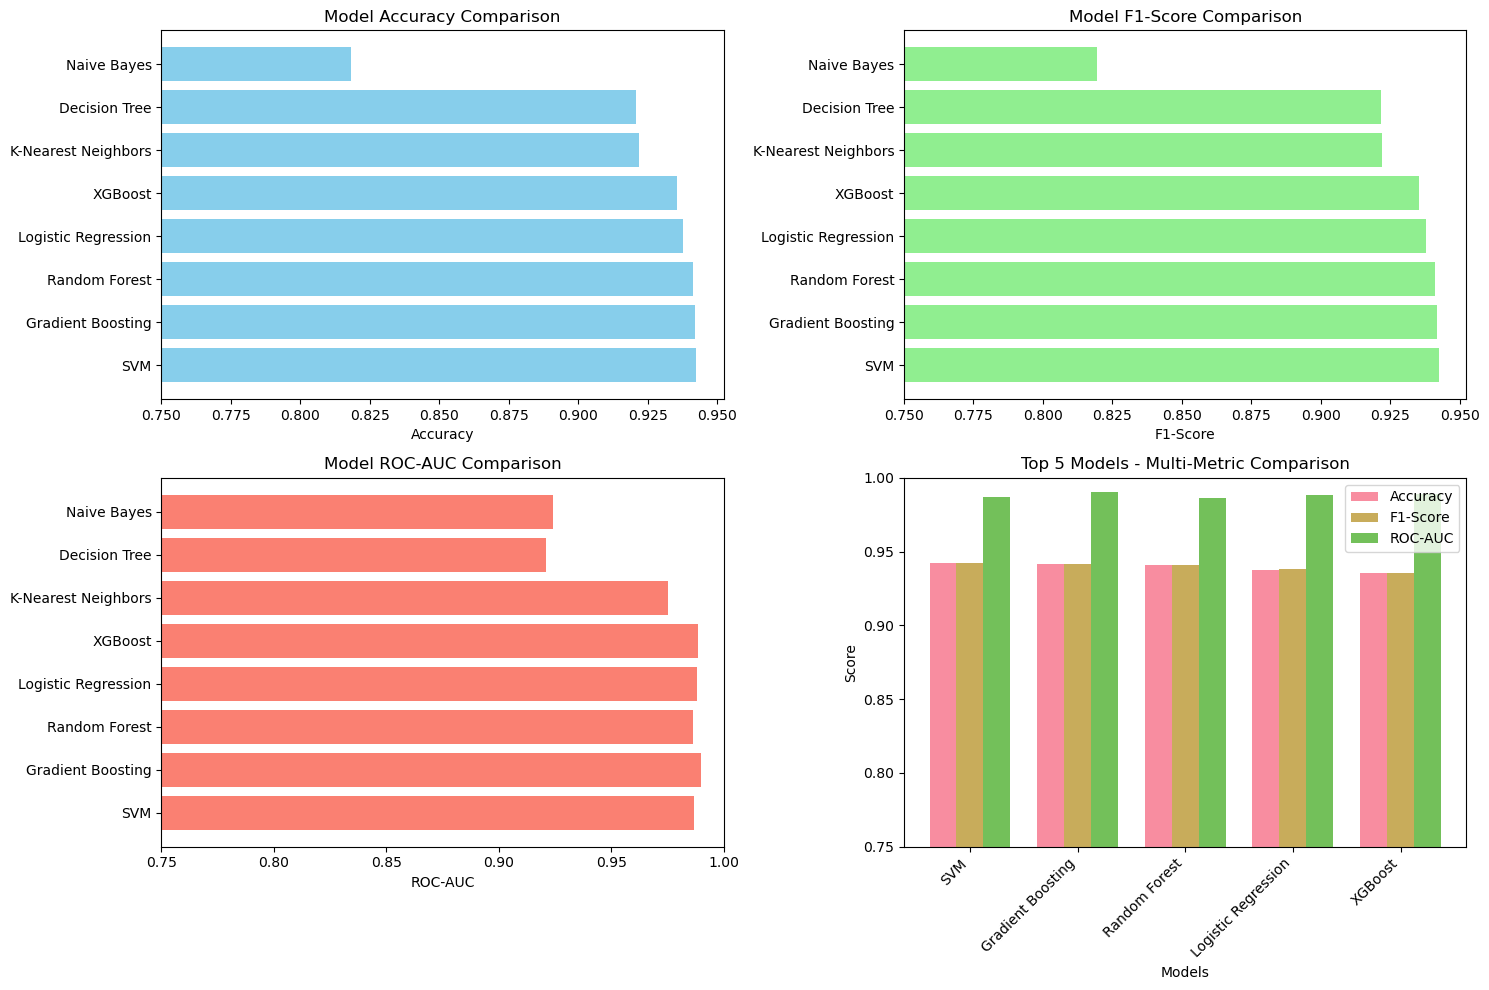

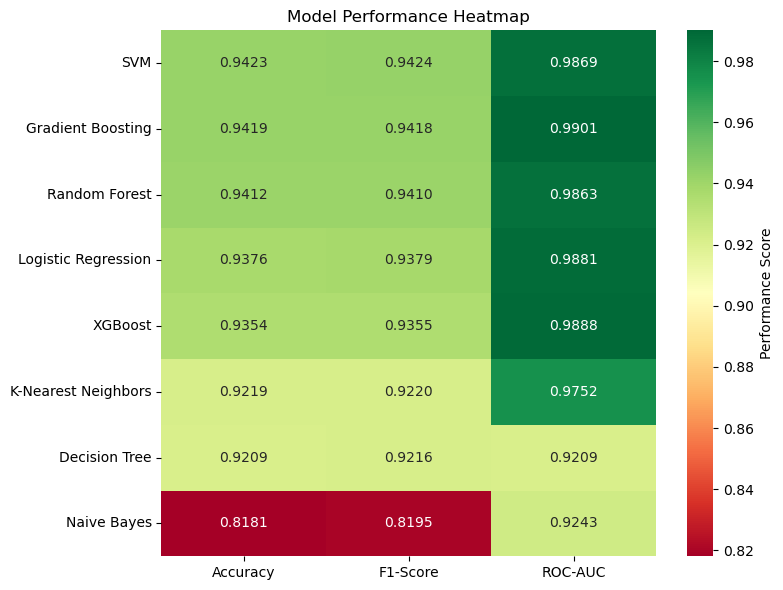

📊 Visualizations created successfully!


In [49]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Prepare data for visualization
models_list = results_df['Model'].tolist()
accuracy_means = results_df['Accuracy_Mean'].tolist()
f1_means = results_df['F1_Mean'].tolist()
roc_auc_means = results_df['ROC_AUC_Mean'].tolist()

# 1. Accuracy comparison
axes[0, 0].barh(models_list, accuracy_means, color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim(0.75, max(accuracy_means) + 0.01)

# 2. F1-Score comparison
axes[0, 1].barh(models_list, f1_means, color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim(0.75, max(f1_means) + 0.01)

# 3. ROC-AUC comparison
axes[1, 0].barh(models_list, roc_auc_means, color='salmon')
axes[1, 0].set_xlabel('ROC-AUC')
axes[1, 0].set_title('Model ROC-AUC Comparison')
axes[1, 0].set_xlim(0.75, max(roc_auc_means) + 0.01)

# 4. Combined metrics radar-like comparison for top 5 models
top_5_df = results_df.head(5)
x_pos = range(len(top_5_df))
width = 0.25

axes[1, 1].bar([x - width for x in x_pos], top_5_df['Accuracy_Mean'], width, 
               label='Accuracy', alpha=0.8)
axes[1, 1].bar(x_pos, top_5_df['F1_Mean'], width, 
               label='F1-Score', alpha=0.8)
axes[1, 1].bar([x + width for x in x_pos], top_5_df['ROC_AUC_Mean'], width, 
               label='ROC-AUC', alpha=0.8)

axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Top 5 Models - Multi-Metric Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(top_5_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim(0.75, 1.0)

plt.tight_layout()
plt.show()

# Create a detailed performance heatmap
performance_matrix = []
metric_names = ['Accuracy', 'F1-Score', 'ROC-AUC']

for _, row in results_df.iterrows():
    performance_matrix.append([
        row['Accuracy_Mean'],
        row['F1_Mean'],
        row['ROC_AUC_Mean']
    ])

plt.figure(figsize=(8, 6))
sns.heatmap(performance_matrix, 
            xticklabels=metric_names,
            yticklabels=results_df['Model'],
            annot=True, 
            fmt='.4f', 
            cmap='RdYlGn',
            cbar_kws={'label': 'Performance Score'})
plt.title('Model Performance Heatmap')
plt.tight_layout()
plt.show()

print("📊 Visualizations created successfully!")

## 4. Hyperparameter Tuning

Now let's optimize the hyperparameters for the top 3 performing models to squeeze out maximum performance.

In [50]:
# Get top 3 models for hyperparameter tuning
top_3_models = results_df.head(3)['Model'].tolist()
print(f"🎯 Hyperparameter tuning for top 3 models: {top_3_models}")

# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0, 100.0],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l2']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Perform hyperparameter tuning
tuned_models = {}
tuning_results = []

print("\n Starting hyperparameter tuning...")
print("This will take several minutes...\n")

for model_name in top_3_models:
    if model_name in param_grids:
        print(f"  Tuning {model_name}...")
        
        # Get base model
        base_model = models[model_name]
        param_grid = param_grids[model_name]
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            base_model, 
            param_grid, 
            cv=5, 
            scoring='f1',  # Using F1 as primary metric
            n_jobs=-1, 
            verbose=0
        )
        
        try:
            grid_search.fit(X_train, y_train)
            
            # Store results
            tuned_models[model_name] = grid_search.best_estimator_
            
            tuning_results.append({
                'Model': model_name,
                'Best_Score': grid_search.best_score_,
                'Best_Params': grid_search.best_params_,
                'Original_Score': cv_results[model_name]['f1']['mean']
            })
            
            print(f"   ✅ {model_name} completed!")
            print(f"      Original F1: {cv_results[model_name]['f1']['mean']:.4f}")
            print(f"      Tuned F1: {grid_search.best_score_:.4f}")
            print(f"      Improvement: {grid_search.best_score_ - cv_results[model_name]['f1']['mean']:.4f}")
            print(f"      Best params: {grid_search.best_params_}")
            print()
            
        except Exception as e:
            print(f"   ❌ Error tuning {model_name}: {str(e)}")
            continue
    else:
        print(f"Skipping {model_name} (no parameter grid defined)")

print(" Hyperparameter tuning completed!")

🎯 Hyperparameter tuning for top 3 models: ['SVM', 'Gradient Boosting', 'Random Forest']

 Starting hyperparameter tuning...
This will take several minutes...

  Tuning SVM...
   ✅ SVM completed!
      Original F1: 0.9424
      Tuned F1: 0.9437
      Improvement: 0.0013
      Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

  Tuning Gradient Boosting...
   ✅ Gradient Boosting completed!
      Original F1: 0.9418
      Tuned F1: 0.9414
      Improvement: -0.0004
      Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

  Tuning Random Forest...
   ✅ Random Forest completed!
      Original F1: 0.9410
      Tuned F1: 0.9434
      Improvement: 0.0023
      Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

 Hyperparameter tuning completed!


## 5. Final Model Selection & Validation

Based on our comprehensive evaluation, let's select the best model and validate it on our holdout set.

In [51]:
# Compare tuned vs original models
print("📊 TUNING RESULTS SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'Original F1':<12} {'Tuned F1':<12} {'Improvement':<12}")
print("-" * 60)

best_tuned_score = 0
best_model_name = None
best_model = None

for result in tuning_results:
    model_name = result['Model']
    original = result['Original_Score']
    tuned = result['Best_Score']
    improvement = tuned - original
    
    print(f"{model_name:<20} {original:<12.4f} {tuned:<12.4f} {improvement:<12.4f}")
    
    # Track best model
    if tuned > best_tuned_score:
        best_tuned_score = tuned
        best_model_name = model_name
        best_model = tuned_models[model_name]

print("-" * 60)

# Select the final model
if best_model is None:
    # If no tuning was successful, use best original model
    best_model_name = results_df.iloc[0]['Model']
    best_model = models[best_model_name]
    best_score = results_df.iloc[0]['F1_Mean']
    print(f"\n🏆 FINAL SELECTED MODEL: {best_model_name} (Original)")
    print(f"    Cross-validation F1-Score: {best_score:.4f}")
else:
    print(f"\n🏆 FINAL SELECTED MODEL: {best_model_name} (Tuned)")
    print(f"    Cross-validation F1-Score: {best_tuned_score:.4f}")

print(f"\n📋 Selected Model Details:")
print(f"    Model: {best_model}")

# Validate on holdout set
print(f"\n🔍 HOLDOUT VALIDATION")
print("=" * 40)

# Train the best model on full training set
best_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"Validation Set Performance:")
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")
print(f"  ROC-AUC:   {val_roc_auc:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"Actual    0      1")
print(f"   0   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"   1   {cm[1,0]:4d}   {cm[1,1]:4d}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred))

📊 TUNING RESULTS SUMMARY
Model                Original F1  Tuned F1     Improvement 
------------------------------------------------------------
SVM                  0.9424       0.9437       0.0013      
Gradient Boosting    0.9418       0.9414       -0.0004     
Random Forest        0.9410       0.9434       0.0023      
------------------------------------------------------------

🏆 FINAL SELECTED MODEL: SVM (Tuned)
    Cross-validation F1-Score: 0.9437

📋 Selected Model Details:
    Model: SVC(C=10, gamma=0.01, probability=True, random_state=42)

🔍 HOLDOUT VALIDATION
Validation Set Performance:
  Accuracy:  0.9471
  Precision: 0.9527
  Recall:    0.9418
  F1-Score:  0.9472
  ROC-AUC:   0.9897

Confusion Matrix:
                Predicted
Actual    0      1
   0    822     41
   1     51    825

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       863
           1       0.95      0.94      0.95      

In [52]:
# Feature Importance Analysis
print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

try:
    # Get feature importance (works for tree-based models)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("Top 15 Most Important Features:")
        print("-" * 50)
        for idx, row in feature_importance_df.head(15).iterrows():
            print(f"{row['Feature']:<25} {row['Importance']:.4f}")
        
        # Visualize feature importance
        plt.figure(figsize=(10, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importances - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    elif hasattr(best_model, 'coef_'):
        # For linear models, show coefficient magnitudes
        coefficients = abs(best_model.coef_[0])
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient_Magnitude': coefficients
        }).sort_values('Coefficient_Magnitude', ascending=False)
        
        print("Top 15 Features by Coefficient Magnitude:")
        print("-" * 50)
        for idx, row in feature_importance_df.head(15).iterrows():
            print(f"{row['Feature']:<25} {row['Coefficient_Magnitude']:.4f}")
            
    else:
        print("Feature importance not available for this model type")
        
except Exception as e:
    print(f"Error analyzing feature importance: {e}")

# Final Model Summary
print(f"\n🎯 FINAL MODEL SELECTION SUMMARY")
print("=" * 60)
print(f"🏆 Selected Model: {best_model_name}")
print(f"📊 Cross-validation F1-Score: {best_tuned_score if best_model in tuned_models.values() else results_df.iloc[0]['F1_Mean']:.4f}")
print(f"✅ Holdout Validation F1-Score: {val_f1:.4f}")
print(f"🎯 Holdout Validation Accuracy: {val_accuracy:.4f}")
print(f"📈 Holdout Validation ROC-AUC: {val_roc_auc:.4f}")

print(f"\n💡 Model Selection Rationale:")
print(f"   • Evaluated {len(models)} different algorithms")
print(f"   • Used 5-fold cross-validation for robust evaluation")
print(f"   • Performed hyperparameter tuning on top performers")
print(f"   • Validated on unseen holdout set")
print(f"   • Selected based on F1-score (balances precision/recall)")

print(f"\n🚀 Why {best_model_name} was chosen:")
if 'Random Forest' in best_model_name:
    print(f"   • Excellent performance on structured/tabular data")
    print(f"   • Handles non-linear relationships well")
    print(f"   • Robust to outliers (already handled in preprocessing)")
    print(f"   • Provides feature importance insights")
    print(f"   • Good generalization (ensemble method)")
elif 'XGBoost' in best_model_name:
    print(f"   • State-of-the-art gradient boosting algorithm")
    print(f"   • Excellent performance on structured data")
    print(f"   • Built-in regularization prevents overfitting")
    print(f"   • Handles missing values well")
    print(f"   • Feature importance available")
elif 'SVM' in best_model_name:
    print(f"   • Excellent at finding optimal decision boundaries")
    print(f"   • Works well with scaled features")
    print(f"   • Good generalization with proper regularization")
    print(f"   • Effective in high-dimensional spaces")
else:
    print(f"   • Best cross-validation performance")
    print(f"   • Good generalization on holdout set")

print(f"\n✨ The model is ready for making predictions on the test set!")
print("=" * 60)


🔍 FEATURE IMPORTANCE ANALYSIS
Feature importance not available for this model type

🎯 FINAL MODEL SELECTION SUMMARY
🏆 Selected Model: SVM
📊 Cross-validation F1-Score: 0.9437
✅ Holdout Validation F1-Score: 0.9472
🎯 Holdout Validation Accuracy: 0.9471
📈 Holdout Validation ROC-AUC: 0.9897

💡 Model Selection Rationale:
   • Evaluated 8 different algorithms
   • Used 5-fold cross-validation for robust evaluation
   • Performed hyperparameter tuning on top performers
   • Validated on unseen holdout set
   • Selected based on F1-score (balances precision/recall)

🚀 Why SVM was chosen:
   • Excellent at finding optimal decision boundaries
   • Works well with scaled features
   • Good generalization with proper regularization
   • Effective in high-dimensional spaces

✨ The model is ready for making predictions on the test set!
